In [1]:
#process DHL data
import pandas as pd
import numpy as np
from patsy import dmatrices
import matplotlib.pyplot as plt
import datetime as dt
from pygam import LinearGAM
import statsmodels.api as sm
import statsmodels.formula.api as smf
volume_filepath = "/Volumes/C19GiGdata/DHL_Parcel/Daily_total_volume.csv"
volume_loc_filepath = "/Volumes/C19GiGdata/DHL_Parcel/Daily_volume_by_site.csv"
driver_cons_filepath = "/Volumes/C19GiGdata/DHL_Parcel/driver_cons.csv"
drivers_croyden_filepath = "/Volumes/C19GiGdata/DHL_Parcel/Driver_details_croyden.csv"
drivers_dundee_filepath = "/Volumes/C19GiGdata/DHL_Parcel/Driver_details_dundee.csv"
drivers_middleton_filepath = "/Volumes/C19GiGdata/DHL_Parcel/Driver_details_middleton.csv"

In [2]:
tot_volume = pd.read_csv(volume_filepath,header = 2,usecols=[0,1,2],skiprows=range(249,270))
drivers_cons = pd.read_csv(driver_cons_filepath,usecols=[0,1,2,3],skiprows=range(187,190))

drivers_cons = drivers_cons.rename(columns={"Unnamed: 0": "day_of_week","Unnamed: 1": "Date"})
local_volumes = pd.read_csv(volume_loc_filepath,header=4,usecols=range(489),skiprows=[65])

croyden_drivers = pd.read_csv(drivers_croyden_filepath)
dundee_drivers = pd.read_csv(drivers_dundee_filepath)
middleton_drivers = pd.read_csv(drivers_middleton_filepath)
print(tot_volume)

    Collection Date  No of Consignments  No of Items
0        2020-01-01               31445        37187
1        2020-01-02              199900       261961
2        2020-01-03              182247       238329
3        2020-01-04                5913         6759
4        2020-01-05               28808        34464
..              ...                 ...          ...
241      2020-08-29                7135         9831
242      2020-08-30                9850        13191
243      2020-08-31               78368        91513
244      2020-09-01              371439       461902
245      2020-09-02              256867       340270

[246 rows x 3 columns]


Look at weekly consignments
Develop model of daily variation
Develop model of inter driver vairation
Develop model of driver day-to-day variation
Spatial model?

In [4]:
DTdate = []
WDkey = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
for i in np.arange(len(drivers_cons["Date"])):
    DTdate.append(dt.datetime.strptime(drivers_cons["Date"][i] + "-2020","%d-%b-%Y"))
    if np.isnan(drivers_cons['no of cons'][i]):
        print(drivers_cons['no of cons'][i])
        drivers_cons['no of cons'][i] = 0
        drivers_cons['no of drivers'][i] = 0
drivers_cons['date.python'] = DTdate

Compare weekly totals for orders received and orders sent
weekly totals sent is a good measure of demand on deliveries but only goes back to March
tracks weekly totals received well if offset by one day, however received no's go back to Jan
maybe use received to produce smooth curve -> fit neg bin to data with demand curve as driver
or, simply use weekly totals as driver, and fit weekday effect

83.62541685615962

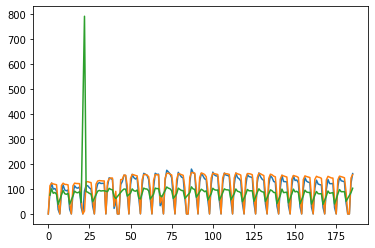

In [11]:

Weekly_tot_sent = [0]
j = 0
for i in np.arange(len(drivers_cons['date.python'])):
    if drivers_cons['day_of_week'][i] == WDkey[0]:
        Weekly_tot_sent.append(0)
        j += 1
    Weekly_tot_sent[j] += drivers_cons['no of cons'][i]

plt.plot(drivers_cons['no of cons']/2000)
plt.plot(drivers_cons['no of drivers']/20)
plt.plot(drivers_cons['no of cons'][drivers_cons['no of cons']>0]/drivers_cons['no of drivers'][drivers_cons['no of cons']>0])
ratio = drivers_cons['no of cons'][drivers_cons['no of cons']>0]/drivers_cons['no of drivers'][drivers_cons['no of cons']>0]
np.mean(ratio[ratio<500])

Fit demand curve to orders received using linear GAM

In [ ]:
DTdate = []
Weekday = []
for i in np.arange(len(tot_volume["Collection Date"])):
    DTdate.append(dt.datetime.strptime(tot_volume["Collection Date"][i],"%Y-%m-%d"))
    Weekday.append(WDkey[DTdate[i].weekday()])
tot_volume['date.python'] = DTdate
tot_volume['day_of_week'] = Weekday
Weekly_tot_coll = [0]
j = 0
for i in np.arange(len(tot_volume['date.python'])):
    if tot_volume['day_of_week'][i] == WDkey[6]:
        Weekly_tot_coll.append(0)
        j += 1
    Weekly_tot_coll[j] += tot_volume['No of Consignments'][i]
    
plt.plot(np.arange(len(Weekly_tot_coll)),Weekly_tot_coll)
plt.plot(np.arange(len(Weekly_tot_coll) - len(Weekly_tot_sent),len(Weekly_tot_coll)),Weekly_tot_sent)

In [ ]:
#fill in missing days
tD = drivers_cons['date.python'][0] - tot_volume['date.python'][0]
start_df = pd.DataFrame()
Dates = []
Odate = []
Dow = []
Jan01 = dt.datetime.strptime("2020-01-01","%Y-%m-%d")
for j in np.arange(tD.days):
    Dates.append(Jan01 + dt.timedelta(days=int(j)))
    Odate.append(Dates[j].strftime("%d-%b")) 
    Dow.append(WDkey[Dates[j].weekday()])
start_df['day_of_week'] = Dow
start_df['Date'] = Odate
start_df['no of drivers'] = np.zeros(tD.days)
start_df['no of cons'] = np.zeros(tD.days)
start_df['date.python'] = Dates
drivers_cons_new = pd.concat([start_df, drivers_cons], ignore_index=True)

In [ ]:
#fit demand curve
dtime = np.arange(len(tot_volume['date.python']))
X = dtime
Y = tot_volume['No of Consignments']
gam = LinearGAM().fit(X, Y)
gam.summary()

Comapre with weekly data (orders per day)

In [3]:
pdep, cint = gam.partial_dependence(0,X=X,width=.95)
fig,ax = plt.subplots(1,1,figsize=(8,4))
ax.plot(X,gam.coef_[-1]*np.ones(len(X)) + pdep, c='k')
ax.plot(X,gam.coef_[-1]*np.ones(len(X)) + cint[:, 0], c='grey', ls='--')
ax.plot(X,gam.coef_[-1]*np.ones(len(X)) + cint[:, 1], c='grey', ls='--')
Ylen = len(Weekly_tot_coll)
#ax.plot(np.arange((Ylen - len(Weekly_tot_sent)),Ylen)*7,np.array(Weekly_tot_sent)/7,c='C1')
ax.plot(tot_volume['Collection Date'],tot_volume['No of Consignments'],'--',c='C0')
xticks = []
for date in tot_volume['Collection Date']:
    if date[-2:] == '01':
        xticks.append(date)
ax.set_xticks(xticks)
plt.setp(ax.get_xticklabels(), rotation=90)
ax.set_xlabel('Date')
ax.set_ylabel('Consignments received')
plt.show()
dates = []
for d in tot_volume['date.python']:
    dates.append(d.strftime("%d/%m/%y"))
exportdf = pd.DataFrame({'Dates': dates, 'Demand': gam.coef_[-1]*np.ones(len(X)) + pdep,
                        'Demand Upper Conf': gam.coef_[-1]*np.ones(len(X)) + cint[:, 1],
                        'Demand Lower Conf': gam.coef_[-1]*np.ones(len(X)) + cint[:, 0]})
exportdf.to_pickle('DHL_parcel_demand.pkl')

NameError: name 'gam' is not defined

Remove days off from dataset (Sundays and BHs)

In [13]:
Sun = tot_volume['day_of_week'] == 'Sunday'
BH = drivers_cons_new['no of cons'] == 0.
NonNan = np.isnan(drivers_cons_new['no of cons'])

time = dtime[Sun | BH | NonNan == False]
demand = gam.coef_[-1] + np.array(pdep[Sun | BH | NonNan == False])
demand_full = gam.coef_[-1] + np.array(pdep)
dow = drivers_cons_new['day_of_week'][Sun | BH | NonNan == False]

Fit daily rates globally, because of data available

In [10]:
Sun_dc = drivers_cons['day_of_week'] == 'Sunday'
BH_dc = drivers_cons['no of cons'] == 0.
NonNan_dc = np.isnan(drivers_cons['no of cons'])

Y = drivers_cons['no of cons'][Sun_dc | BH_dc | NonNan_dc == False]
X1 = gam.coef_[-1] + np.array(pdep[int(tD.days):])[Sun_dc | BH_dc | NonNan_dc == False]
X2 = drivers_cons['day_of_week'][Sun_dc | BH_dc | NonNan_dc == False]

fitdata = {'CONS': Y,\
           'DAY_OF_WEEK': X2,\
           'DEMAND': X1}

df_train = pd.DataFrame(fitdata, columns=['CONS','DAY_OF_WEEK','DEMAND'])
expr = """CONS ~ DAY_OF_WEEK + DEMAND"""
y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
df_train['DD_LAMBDA'] = poisson_training_results.mu
df_train['AUX_OLS_DEP'] = df_train.apply(lambda x: ((x['CONS'] - x['DD_LAMBDA'])**2 - x['CONS']) / x['DD_LAMBDA'], axis=1)
ols_expr = """AUX_OLS_DEP ~ DD_LAMBDA - 1"""
aux_olsr_results = smf.ols(ols_expr, df_train).fit()
alpha = aux_olsr_results.params['DD_LAMBDA']
res_lambda = 1
res_alpha = 1
while res_alpha > 1E-9 or res_lambda > 1E-9:
    lambdas_old = df_train['DD_LAMBDA'].copy()
    alpha_old = alpha.copy()
    negbin_training_results = sm.GLM(y_train, X_train, family=sm.families.NegativeBinomial(alpha=alpha)).fit()
    df_train['DD_LAMBDA'] = negbin_training_results.mu
    df_train['AUX_OLS_DEP'] = df_train.apply(lambda x: ((x['CONS'] - x['DD_LAMBDA'])**2 - x['CONS']) / x['DD_LAMBDA'], axis=1)
    aux_olsr_results = smf.ols(ols_expr, df_train).fit()
    alpha = aux_olsr_results.params['DD_LAMBDA']
    res_lambda = np.sum((df_train['DD_LAMBDA'] - lambdas_old)**2)/lambdas_old.size
    res_alpha = (alpha - alpha_old)**2
    print(alpha,res_alpha,res_lambda)
print('alpha fit t_value', aux_olsr_results.tvalues)
fitted_summary_frame = negbin_training_results.get_prediction(X_train).summary_frame()
fitted_counts_global=fitted_summary_frame['mean']
print(negbin_training_results.summary())
print(negbin_training_results.conf_int(alpha=0.05))

exportdf = pd.DataFrame({'Params': negbin_training_results.params.index.to_numpy(),\
                         'Coeffs': negbin_training_results.params.to_numpy(),\
                         'CIlower': negbin_training_results.conf_int(alpha=0.05)[0].to_numpy(),\
                         'CIupper': negbin_training_results.conf_int(alpha=0.05)[1].to_numpy()})
exportdf.to_pickle('Weekday_demand_fit_DHLP.pkl')

0.018817857077694615 5.5764969779066795e-08 13610051.804047832
0.01881786078235392 1.3724500566275032e-17 0.0009555543497971943
0.018817860782430362 5.8434290043773866e-27 2.808113398778167e-13
alpha fit t_value DD_LAMBDA    1.831099
dtype: float64
                 Generalized Linear Model Regression Results                  
Dep. Variable:                   CONS   No. Observations:                  156
Model:                            GLM   Df Residuals:                      149
Model Family:        NegativeBinomial   Df Model:                            6
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1962.1
Date:                Wed, 14 Oct 2020   Deviance:                       431.49
Time:                        12:29:58   Pearson chi2:                     428.
No. Iterations:                     7                                         
Covariance Type:            nonrobust   

Fit site rates weekly - no of consignments is received rather than sent, so count Sun-Sat

In [19]:
Sun_dc = drivers_cons['day_of_week'] == 'Sunday'
BH_dc = drivers_cons['no of cons'] == 0.
NonNan_dc = np.isnan(drivers_cons['no of cons'])

Y = drivers_cons['no of drivers'][Sun_dc | BH_dc | NonNan_dc == False]
X1 = gam.coef_[-1] + np.array(pdep[int(tD.days):])[Sun_dc | BH_dc | NonNan_dc == False]
X2 = drivers_cons['day_of_week'][Sun_dc | BH_dc | NonNan_dc == False]

fitdata = {'DRIVERS': Y,\
           'DAY_OF_WEEK': X2,\
           'DEMAND': X1}

df_train = pd.DataFrame(fitdata, columns=['DRIVERS','DAY_OF_WEEK','DEMAND'])
expr = """DRIVERS ~ DAY_OF_WEEK + DEMAND"""
y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
df_train['DD_LAMBDA'] = poisson_training_results.mu
df_train['AUX_OLS_DEP'] = df_train.apply(lambda x: ((x['DRIVERS'] - x['DD_LAMBDA'])**2 - x['DRIVERS']) / x['DD_LAMBDA'], axis=1)
ols_expr = """AUX_OLS_DEP ~ DD_LAMBDA - 1"""
aux_olsr_results = smf.ols(ols_expr, df_train).fit()
alpha = aux_olsr_results.params['DD_LAMBDA']
res_lambda = 1
res_alpha = 1
while res_alpha > 1E-9 or res_lambda > 1E-9:
    lambdas_old = df_train['DD_LAMBDA'].copy()
    alpha_old = alpha.copy()
    negbin_training_results = sm.GLM(y_train, X_train, family=sm.families.NegativeBinomial(alpha=alpha)).fit()
    df_train['DD_LAMBDA'] = negbin_training_results.mu
    df_train['AUX_OLS_DEP'] = df_train.apply(lambda x: ((x['DRIVERS'] - x['DD_LAMBDA'])**2 - x['DRIVERS']) / x['DD_LAMBDA'], axis=1)
    aux_olsr_results = smf.ols(ols_expr, df_train).fit()
    alpha = aux_olsr_results.params['DD_LAMBDA']
    res_lambda = np.sum((df_train['DD_LAMBDA'] - lambdas_old)**2)/lambdas_old.size
    res_alpha = (alpha - alpha_old)**2
    print(alpha,res_alpha,res_lambda)
print('alpha fit t_value', aux_olsr_results.tvalues)
fitted_summary_frame = negbin_training_results.get_prediction(X_train).summary_frame()
fitted_counts_global=fitted_summary_frame['mean']
print(negbin_training_results.summary())
print(negbin_training_results.conf_int(alpha=0.05))

exportdf = pd.DataFrame({'Params': negbin_training_results.params.index.to_numpy(),\
                         'Coeffs': negbin_training_results.params.to_numpy(),\
                         'CIlower': negbin_training_results.conf_int(alpha=0.05)[0].to_numpy(),\
                         'CIupper': negbin_training_results.conf_int(alpha=0.05)[1].to_numpy()})
exportdf.to_pickle('Weekday_demand_driverfit_DHLP.pkl')

0.015614207177352268 1.074779446488837e-08 486.53124888932655
0.01561424892430182 1.742807796879999e-15 3.077055493815676e-05
0.015614248941197914 2.85477989043425e-22 4.897483470751337e-12
alpha fit t_value DD_LAMBDA    2.270156
dtype: float64
                 Generalized Linear Model Regression Results                  
Dep. Variable:                DRIVERS   No. Observations:                  156
Model:                            GLM   Df Residuals:                      149
Model Family:        NegativeBinomial   Df Model:                            6
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1244.3
Date:                Thu, 15 Oct 2020   Deviance:                       399.22
Time:                        10:30:04   Pearson chi2:                     213.
No. Iterations:                     6                                         
Covariance Type:            nonrobust       

In [21]:
np.mean(drivers_cons['no of drivers'][drivers_cons['day_of_week'] == 'Tuesday'])

2996.4074074074074

In [11]:
sites = local_volumes['Delivery Site'].unique()
nweeks = 0
WTs = []
WDs = []
for j in np.arange(len(sites)):
    DH = local_volumes[local_volumes['Delivery Site'] == sites[j]]
    Weekly_tot = [0]
    Weekly_demand = [0]
    k = 0
    k2 = 0
    for i in np.arange(len(drivers_cons['date.python'])):
        if drivers_cons['day_of_week'][i] == WDkey[0]:
            Weekly_demand.append(0)
            k2 += 1
        if drivers_cons['day_of_week'][i] == WDkey[6]:
            Weekly_tot.append(0)
            k += 1
        if np.isnan(DH.iloc[0,2*i+1]) == False:
            Weekly_tot[k] += DH.iloc[0,2*i+1]
        Weekly_demand[k2] += demand_full[i]/52
    WTs.append(Weekly_tot)
    WDs.append(Weekly_demand)

W = np.zeros((len(sites),len(WTs[0])-2))
WD = np.zeros((len(sites),len(WTs[0])-2))
S = np.zeros((len(sites),len(WTs[0])-2),dtype=(np.unicode,16))
for i in np.arange(len(sites)):
    W[i] = WTs[i][1:-1]
    WD[i] = WDs[i][1:-1]
    S[i,:] = sites[i]

In [12]:
fitdata = {'CONS': W.flatten(),\
           'SITE': S.flatten(),\
           'DEMAND': WD.flatten()}

df_train = pd.DataFrame(fitdata, columns=['CONS','DEMAND','SITE'])
expr = """CONS ~ DEMAND + SITE"""
y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
df_train['DD_LAMBDA'] = poisson_training_results.mu
df_train['AUX_OLS_DEP'] = df_train.apply(lambda x: ((x['CONS'] - x['DD_LAMBDA'])**2 - x['CONS']) / x['DD_LAMBDA'], axis=1)
ols_expr = """AUX_OLS_DEP ~ DD_LAMBDA - 1"""
aux_olsr_results = smf.ols(ols_expr, df_train).fit()
alpha = aux_olsr_results.params['DD_LAMBDA']
res_lambda = 1
res_alpha = 1
while res_alpha > 1E-9 or res_lambda > 1E-9:
    lambdas_old = df_train['DD_LAMBDA'].copy()
    alpha_old = alpha.copy()
    negbin_training_results = sm.GLM(y_train, X_train, family=sm.families.NegativeBinomial(alpha=alpha)).fit()
    df_train['DD_LAMBDA'] = negbin_training_results.mu
    df_train['AUX_OLS_DEP'] = df_train.apply(lambda x: ((x['CONS'] - x['DD_LAMBDA'])**2 - x['CONS']) / x['DD_LAMBDA'], axis=1)
    aux_olsr_results = smf.ols(ols_expr, df_train).fit()
    alpha = aux_olsr_results.params['DD_LAMBDA']
    res_lambda = np.sum((df_train['DD_LAMBDA'] - lambdas_old)**2)/lambdas_old.size
    res_alpha = (alpha - alpha_old)**2
    print(alpha,res_alpha,res_lambda)
print('alpha fit t_value', aux_olsr_results.tvalues)
fitted_summary_frame = negbin_training_results.get_prediction(X_train).summary_frame()
fitted_counts_site=fitted_summary_frame['mean']
print(negbin_training_results.summary())

exportdf = pd.DataFrame({'Params': negbin_training_results.params.index.to_numpy(),\
                         'Coeffs': negbin_training_results.params.to_numpy(),\
                         'CIlower': negbin_training_results.conf_int(alpha=0.05)[0].to_numpy(),\
                         'CIupper': negbin_training_results.conf_int(alpha=0.05)[1].to_numpy()})
exportdf.to_pickle('Site_demand_fit_DHLP.pkl')

0.006283164428406421 6.234556794998472e-08 58328.87556824867
0.006283523849906918 1.2918381501948265e-13 1.4006798337547914
0.006283524361237197 2.61458653676065e-19 2.830324334100592e-06
0.006283524361929287 4.789892354772695e-25 6.050783980811177e-12
alpha fit t_value DD_LAMBDA    22.583625
dtype: float64
                 Generalized Linear Model Regression Results                  
Dep. Variable:                   CONS   No. Observations:                 1560
Model:                            GLM   Df Residuals:                     1499
Model Family:        NegativeBinomial   Df Model:                           60
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -14030.
Date:                Wed, 14 Oct 2020   Deviance:                       3628.1
Time:                        12:30:02   Pearson chi2:                 3.79e+03
No. Iterations:                    10                      

Text(0, 0.5, 'Weekly consignments')

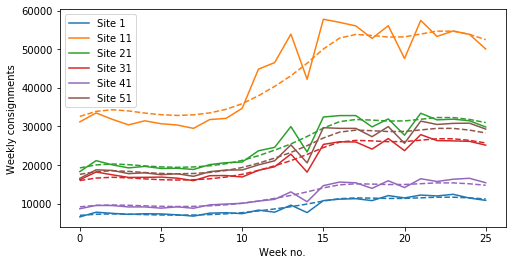

In [13]:

fitted_counts = np.array(fitted_counts_site).reshape(W.shape)
fig,ax = plt.subplots(1,1,figsize=(8,4))
for i in np.arange(6):
    ax.plot(np.transpose(W[i*10,:]),color='C%d'%i,label='Site %d'%(i*10+1))
    ax.plot(np.transpose(fitted_counts[i*10,:]),'--',color='C%d'%i)
ax.legend()
ax.set_xlabel('Week no.')
ax.set_ylabel('Weekly consignments')


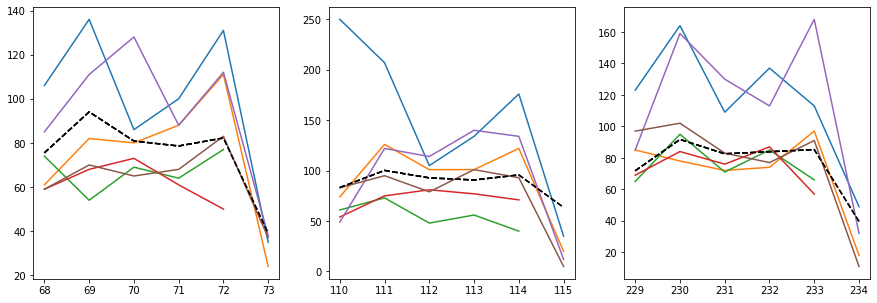

In [14]:
#now to look up individual drivers and compare to site averages

cd_dates = croyden_drivers['SelectDate'].unique()
cd_dates_delta = np.array([],dtype=np.int)
cd_drivers = croyden_drivers['PodDriverName'].unique()
Dates = np.array([])
for date in croyden_drivers['SelectDate']:
    Dates = np.append(Dates,dt.datetime.strptime(date,"%d/%m/%Y"))
    
croyden_drivers['PyDate'] = Dates
PyDates = np.array([])
NDels = [np.array([]),np.array([])]
cind = np.where(sites=='Croydon')[0][0]
k = 0
for date in cd_dates:
    date_select = croyden_drivers['SelectDate'] == date
    PyDates = np.append(PyDates,dt.datetime.strptime(date,"%d/%m/%Y"))
    dtime = PyDates[-1] - dt.datetime.strptime("01/01/2020","%d/%m/%Y")
    cd_dates_delta = np.append(cd_dates_delta,int(dtime.days))
    
    for i in np.arange(2):
        driver_select = croyden_drivers['PodDriverName'] == cd_drivers[i]
        NDels[i] = np.append(NDels[i],np.sum(np.array(date_select)*np.array(driver_select)))

fig,ax = plt.subplots(1,3,figsize=(15,5))        
for i in np.arange(2):
    for n in np.arange(3):
        dates= np.argsort(cd_dates_delta)[n*6:(n+1)*6]
        ax[n].plot(cd_dates_delta[dates],np.transpose(NDels[i][dates]))
for n in np.arange(3):
    dates= np.sort(cd_dates_delta)[n*6:(n+1)*6]
    
    ax[n].plot(dates,drivers_cons_new['no of cons'][dates]/drivers_cons_new['no of drivers'][dates],'--',color='k')        



dn_dates = dundee_drivers['SelectDate'].unique()
dn_dates_delta = np.array([],dtype=np.int)
dn_drivers = dundee_drivers['PodDriverName'].unique()
Dates = np.array([])
for date in dundee_drivers['SelectDate']:
    Dates = np.append(Dates,dt.datetime.strptime(date,"%d/%m/%Y"))
    
dundee_drivers['PyDate'] = Dates
PyDates = np.array([])
NDels = [np.array([]),np.array([])]
cind = np.where(sites=='Dundee')[0][0]
k = 0
for date in dn_dates:
    date_select = dundee_drivers['SelectDate'] == date
    PyDates = np.append(PyDates,dt.datetime.strptime(date,"%d/%m/%Y"))
    dtime = PyDates[-1] - dt.datetime.strptime("01/01/2020","%d/%m/%Y")
    dn_dates_delta = np.append(dn_dates_delta,int(dtime.days))
    
    for i in np.arange(2):
        driver_select = dundee_drivers['PodDriverName'] == dn_drivers[i]
        NDels[i] = np.append(NDels[i],np.sum(np.array(date_select)*np.array(driver_select)))
      
for i in np.arange(2):
    for n in np.arange(3):
        dates= np.argsort(dn_dates_delta)[n*5:(n+1)*5]
        ax[n].plot(dn_dates_delta[dates],np.transpose(NDels[i][dates]))
for n in np.arange(3):
    dates= np.sort(dn_dates_delta)[n*5:(n+1)*5]
    ax[n].plot(dates,drivers_cons_new['no of cons'][dates]/drivers_cons_new['no of drivers'][dates],'--',color='k') 

md_dates = middleton_drivers['SelectDate'].unique()
md_dates_delta = np.array([],dtype=np.int)
md_drivers = middleton_drivers['PodDriverName'].unique()
Dates = np.array([])
for date in middleton_drivers['SelectDate']:
    Dates = np.append(Dates,dt.datetime.strptime(date,"%d/%m/%Y"))
    
middleton_drivers['PyDate'] = Dates
PyDates = np.array([])
NDels = [np.array([]),np.array([])]
cind = np.where(sites=='Middleton')[0][0]
k = 0
for date in md_dates:
    date_select = middleton_drivers['SelectDate'] == date
    PyDates = np.append(PyDates,dt.datetime.strptime(date,"%d/%m/%Y"))
    dtime = PyDates[-1] - dt.datetime.strptime("01/01/2020","%d/%m/%Y")
    md_dates_delta = np.append(md_dates_delta,int(dtime.days))
    
    for i in np.arange(2):
        driver_select = middleton_drivers['PodDriverName'] == md_drivers[i]
        NDels[i] = np.append(NDels[i],np.sum(np.array(date_select)*np.array(driver_select)))

for i in np.arange(2):
    for n in np.arange(3):
        dates= np.argsort(md_dates_delta)[n*6:(n+1)*6]
        ax[n].plot(md_dates_delta[dates],np.transpose(NDels[i][dates]))
for n in np.arange(3):
    dates= np.sort(md_dates_delta)[n*6:(n+1)*6]
    ax[n].plot(dates,drivers_cons_new['no of cons'][dates]/drivers_cons_new['no of drivers'][dates],'--',color='k') 

In [193]:
valid_dates = Sun | BH | NonNan
local_cons = np.zeros((len(sites),np.sum(valid_dates)))
k = 0
for n in np.arange(len(valid_dates)):
    if valid_dates[n]:
        if k > 0:
            local_cons[:,k] = local_volumes['No of Consignments.%d'%n]
        else:
            local_cons[:,k] = local_volumes['No of Consignments']
        k += 1
valid_sites = np.ones(len(sites),dtype=np.bool)
for j in np.arange(len(sites)):
    if np.any(np.isnan(local_cons[j,:])):
        valid_sites[j] = False
print(np.sum(valid_sites))
local_cons = local_cons[valid_sites]
av_site_use = np.mean(local_cons,axis=1)
mean_use = np.mean(local_cons)
print(np.quantile(av_site_use,0.05)/mean_use,np.quantile(av_site_use,0.95)/mean_use)

52
0.27279932368170773 1.8029133711052763


In [169]:
print(local_volumes)

      Delivery Site  No of Consignments  No of Items  No of Consignments.1  \
0          Aberdeen               220.0        301.0                  1313   
1          Basildon               948.0       1157.0                  5659   
2           Belfast              1035.0       1183.0                  3240   
3        Birmingham               881.0       1068.0                  5087   
4       Bournemouth               436.0        474.0                  3254   
5           Bristol               716.0        885.0                  4663   
6      Burgess Hill               662.0        781.0                  4710   
7     Businessprint                 NaN          NaN                     8   
8           Cardiff               610.0        686.0                  3767   
9          Carlisle               266.0        300.0                  2104   
10          Croydon              1406.0       1687.0                  6574   
11         Dartford               968.0       1100.0            